## 기본 세팅

In [ ]:
# drive mount
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import glob
import natsort ## 숫자 정렬용 라이브러리 출처: https://mentha2.tistory.com/171 [행궁동 데이터 엔지니어]

# 확장자
extension = "*.jpg"

# 텍스트 파일이 저장될 경로
save_at = '/content/drive/MyDrive/darknet/pose/' + 'custom.txt'

# 대상 폴더에서 지정한 확장자를 가진 파일들의 경로를 리스트화
path_list = list(glob.glob('/content/drive/MyDrive/img/' + extension))

after_path_list = natsort.natsorted(path_list) # img의 이름들이 담긴 list가 됨

# 파일들의 경로를 텍스트 파일에 추가 및 입력
for file in after_path_list:
    f = open(save_at, 'a')
    f.write(file + "\n")
f.close()

In [ ]:
# class : clear, label / 0, 1로 구분
from tqdm import tqdm 

txt_list = list(glob.glob('/content/drive/MyDrive/img/' + '*.txt'))

clear = 0
label = 0

for t in tqdm(txt_list):
  f = open(t, 'r')
  
  while True:
    line = f.readline()
    if not line: break
    
    num = line.split(' ')[0] # class 부분만 읽어오기
    
    if num == '0':
      clear += 1
    else:
      label += 1
  f.close()  

print(f'총 {len(txt_list)}개의 이미지 중 깨끗한 페트병 {clear}개, 라벨있는 페트병 {label}개')

100%|██████████| 3175/3175 [27:21<00:00,  1.93it/s]

총 3175개의 이미지 중 깨끗한 페트병 1332개, 라벨있는 페트병 2252개


## darknet 과 yolo의 학습 방법

- 참고링크
  - https://github.com/tzutalin/labelImg : labelimg 사용
  - https://colab.research.google.com/drive/1_GdoqCJWXsChrOiY8sZMr_zbr_fH-0Fg?usp=sharing#scrollTo=iZULaGX7_H1u
  - https://developer-thislee.tistory.com/18?category=818795
  - 


- 필요 file

1. custom.name : class의 이름
2. custom.txt : img파일들의 경로 나열
3. yolov4.cfg : config file class와 fillter 수정해야함
4. custom.data : class의 갯수, custom.txt path, custom.name path, backup folder path

## 코랩에서 Darknet 이용해서 커스텀 데이터 학습

In [ ]:
## Cuda 버전 확인
!/usr/local/cuda/bin/nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


In [ ]:
# Cuda와 호환되는 버전의 cudnn 설치
!tar -xzvf /content/drive/MyDrive/cudnn-11.1-linux-x64-v8.0.5.39.tgz -C /usr/local/ > /dev/null

In [ ]:
# cudnn 버전 확인
!cat /usr/local/cuda/include/cudnn_version.h | grep CUDNN_MAJOR -A 2

#define CUDNN_MAJOR 8
#define CUDNN_MINOR 0
#define CUDNN_PATCHLEVEL 5
--
#define CUDNN_VERSION (CUDNN_MAJOR * 1000 + CUDNN_MINOR * 100 + CUDNN_PATCHLEVEL)

#endif /* CUDNN_VERSION_H */


In [ ]:
# darknet 다운로드
%cd /content/
!git clone https://github.com/AlexeyAB/darknet.git
%ls

/content
Cloning into 'darknet'...
remote: Enumerating objects: 15368, done.
remote: Total 15368 (delta 0), reused 0 (delta 0), pack-reused 15368
Receiving objects: 100% (15368/15368), 13.98 MiB | 19.21 MiB/s, done.
Resolving deltas: 100% (10335/10335), done.
darknet/  drive/  sample_data/


In [ ]:
# Makrfile 변경
%cd /content/darknet/
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile

/content/darknet


In [ ]:
# darknet 컴파일
!make > /dev/null

In [ ]:
# 컴파일한 darknet 드라이브로 복사 https://hanryang1125.tistory.com/17
%cp -r ./darknet /content/drive/MyDrive/darknet

### 학습이 끝난뒤 여기부터 시작

In [ ]:
# darknet 권한 변경 및 실행 테스트
# !wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.conv.137
%cd /content/drive/MyDrive/darknet
!chmod +x ./darknet
!./darknet detector

/content/drive/MyDrive/darknet
 CUDA-version: 11010 (11020), cuDNN: 8.0.5, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 3.2.0
usage: ./darknet detector [train/test/valid/demo/map] [data] [cfg] [weights (optional)]


In [ ]:
# 현재 런타임이 GPU를 사용하고있는지 확인(cuda를 사용하고있는지)
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
# Colab에서 제공해주는 함수
# define helper functions
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()

# use this to upload files
def upload():
  from google.colab import files
  uploaded = files.upload() 
  for name, data in uploaded.items():
    with open(name, 'wb') as f:
      f.write(data)
      print ('saved file', name)

# use this to download a file  
def download(path):
  from google.colab import files
  files.download(path)

In [ ]:
# 접근 권한 부여
!chmod +x custom.data
!chmod +x yolov4.cfg
!chmod +x yolov4.weights
!chmod +x pose/custom.txt
!chmod -R 777 pose

In [ ]:
%ls

a.mp4           chart.png              darknet*         result.txt
a.txt           chart_yolov4_1117.png  data/            yolov4.cfg*
bad.list        chart_yolov4_1119.png  image.txt        yolov4.conv.137
chart_1117.png  chart_yolov4_1120.png  pose/            yolov4.weights*
chart_1119.png  chart_yolov4.png       predictions.jpg
chart_1120.png  custom.data*           result.json


In [ ]:
# .\darknet.exe detector train pose/custom.data pose/yolov4-custom.cfg yolov4.conv.137

In [ ]:
# darknet을 이용하여 학습 
!./darknet detector train custom.data yolov4.cfg yolov4.conv.137 -dont_show

In [ ]:
%ls ./data

라벨2.jpg  box2.jpg  can.jpg      glass.jpg  pet00.jpg  pet1958.jpg  train.txt
2.jpg      box.jpg   dosirak.jpg  라벨.jpg   pet10.jpg  pet1958.txt


In [ ]:
# 만들어진 weights로 테스트 https://pgmrlsh.tistory.com/6
# -ext_output 붙이면 rect 테두리 값을 알 수 있음
!./darknet detector test custom.data yolov4.cfg pose/backup/yolov4_4000.weights data/pet1958.jpg -dont_show -ext_output

 CUDA-version: 11010 (11020), cuDNN: 8.0.5, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 3.2.0
Cannot load image data/labels/32_0.png
Cannot load image data/labels/33_0.png
Cannot load image data/labels/34_0.png
Cannot load image data/labels/35_0.png
Cannot load image data/labels/36_0.png
Cannot load image data/labels/37_0.png
Cannot load image data/labels/38_0.png
Cannot load image data/labels/39_0.png
Cannot load image data/labels/40_0.png
Cannot load image data/labels/41_0.png
Cannot load image data/labels/42_0.png
Cannot load image data/labels/43_0.png
Cannot load image data/labels/44_0.png
Cannot load image data/labels/45_0.png
Cannot load image data/labels/46_0.png
Cannot load image data/labels/47_0.png
Cannot load image data/labels/48_0.png
Cannot load image data/labels/49_0.png
Cannot load image data/labels/50_0.png
Cannot load image data/labels/51_0.png
Cannot load image data/labels/52_0.png
Cannot load image data/labels/53_0.png
Cannot load image data/labels/5

In [ ]:
# 성능 평가 지표
!./darknet detector map custom.data yolov4.cfg pose/backup/yolov4_4000.weights

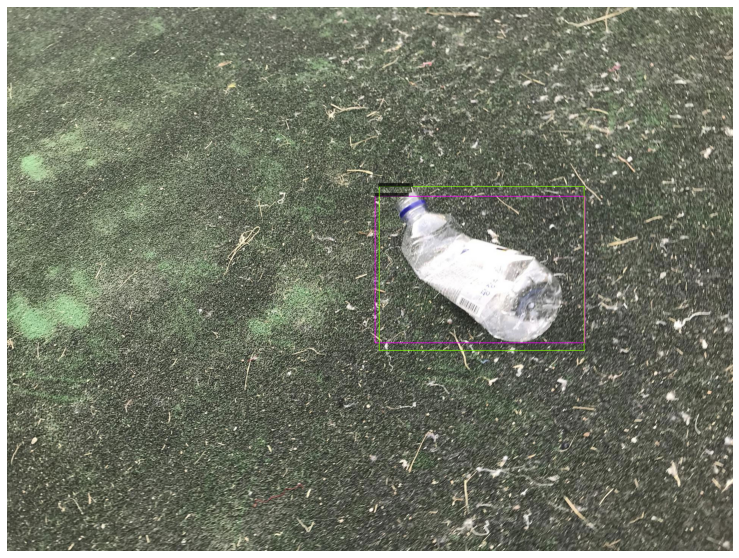

In [ ]:
# show image using our helper function
imShow('predictions.jpg')

In [ ]:
!cat /content/a.txt

## Save Results to .JSON File
Here is an example of saving the multiple image detections to a .JSON file.

In [ ]:
!./darknet detector test custom.data yolov4.cfg pose/backup/yolov4_4000.weights -ext_output -dont_show -out result.json < /content/drive/MyDrive/darknet/image.txt

In [ ]:
download('result.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Saving Results to a .txt File
You can also save the results of running multiple images to a text file.

In [ ]:
!./darknet detector test custom.data yolov4.cfg pose/backup/yolov4_4000.weights -dont_show -ext_output < /content/drive/MyDrive/darknet/image.txt > result.txt

In [ ]:
download('result.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 함수 테스트

In [ ]:
# yolov4 사용 하려면 4.4.0 버전 이상 OpenCv를 사용해야 함
!pip install --upgrade opencv-python

In [ ]:
# app.py
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

classes = []
# class의 이름들
with open("/content/drive/MyDrive/darknet/pose/custom.names", "r") as f:
    classes = [line.strip() for line in f.readlines()]

In [ ]:
# 출처 : https://sleepyjun.github.io/toyproject/mlcat

def yolo(frame, size, score_threshold, nms_threshold):
    net = cv2.dnn.readNetFromDarknet("/content/drive/MyDrive/darknet/yolov4.cfg", "/content/drive/MyDrive/darknet/pose/backup/yolov4_4000.weights")
    net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
    net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)
    layer_names = net.getLayerNames()

    # net.getUnconnectedOutLayers()의 리턴값이 [000, 000, 000] 이었음
    output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]
    # output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]
    # 클래스의 갯수만큼 랜덤 RGB 배열을 생성
    colors = np.random.uniform(0, 255, size=(len(classes), 3))

    # 이미지의 높이, 너비, 채널 받아오기
    height, width, channels = frame.shape

    # 네트워크에 넣기 위한 전처리
    blob = cv2.dnn.blobFromImage(frame, 0.00392, (size, size), (0, 0, 0), True, crop=False)

    # 전처리된 blob 네트워크에 입력
    net.setInput(blob)

    # 결과 받아오기
    outs = net.forward(output_layers)

    # 각각의 데이터를 저장할 빈 리스트
    class_ids = []
    confidences = []
    boxes = []

    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]

            if confidence > 0.1:
                # 탐지된 객체의 너비, 높이 및 중앙 좌표값 찾기
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)

                # 객체의 사각형 테두리 중 좌상단 좌표값 찾기
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)

                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    # 후보 박스(x, y, width, height)와 confidence(상자가 물체일 확률) 출력
    print(f"boxes: {boxes}")
    print(f"confidences: {confidences}")

    # Non Maximum Suppression (겹쳐있는 박스 중 confidence 가 가장 높은 박스를 선택)
    indexes = cv2.dnn.NMSBoxes(boxes, confidences, score_threshold=score_threshold, nms_threshold=nms_threshold)
    
    # 후보 박스 중 선택된 박스의 인덱스 출력
    print(f"indexes: ", end='')
    for index in indexes:
        print(index, end=' ')
    print("\n\n============================== classes ==============================")

    for i in range(len(boxes)):
        if i in indexes:
            x, y, w, h = boxes[i]
            class_name = classes[class_ids[i]]
            label = f"{class_name} {confidences[i]:.2f}"
            color = colors[class_ids[i]]

            # 사각형 테두리 그리기 및 텍스트 쓰기
            cv2.rectangle(frame, (x, y), (x + w, y + h), color, 2)
            cv2.rectangle(frame, (x - 1, y), (x + len(class_name) * 13 + 65, y - 25), color, -1)
            cv2.putText(frame, label, (x, y - 8), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0, 0, 0), 2)
            
            # 탐지된 객체의 정보 출력
            print(f"[{class_name}({i})] conf: {confidences[i]} / x: {x} / y: {y} / width: {w} / height: {h}")

    return frame

### 이미지

In [ ]:
from glob import glob
glob("/content/drive/MyDrive/darknet/data/*.jpg")

['/content/drive/MyDrive/darknet/data/2.jpg',
 '/content/drive/MyDrive/darknet/data/box.jpg',
 '/content/drive/MyDrive/darknet/data/pet10.jpg',
 '/content/drive/MyDrive/darknet/data/라벨.jpg',
 '/content/drive/MyDrive/darknet/data/라벨2.jpg',
 '/content/drive/MyDrive/darknet/data/box2.jpg',
 '/content/drive/MyDrive/darknet/data/can.jpg',
 '/content/drive/MyDrive/darknet/data/glass.jpg',
 '/content/drive/MyDrive/darknet/data/dosirak.jpg']

In [ ]:
image = "/content/drive/MyDrive/darknet/data/라벨2.jpg"
frame = cv2.imread(image)

# 입력 사이즈 리스트 (Yolo 에서 사용되는 네크워크 입력 이미지 사이즈)
# 모델 학습시에 256*256으로 학습시켰기 때문에 256을 사용해주어야함.
size_list = [256, 320, 416, 608]

frame = yolo(frame=frame, size=size_list[0], score_threshold=0.1, nms_threshold=0.4)
cv2_imshow(frame)
cv2.waitKey(0)
cv2.destroyAllWindows()

### 영상

In [ ]:
from imutils.video import FPS
import numpy as np # 파이썬 행렬 수식 및 수치 계산 처리 모듈
import easydict # argparse가 쥬피터에선 안됨
import imutils # 파이썬 OpenCV가 제공하는 기능 중 복잡하고 사용성이 떨어지는 부분을 보완(이미지 또는 비디오 스트림 파일 처리 등)
import time # 시간 처리 모듈

In [ ]:
video_path = '/content/drive/MyDrive/T1_PJ/DATA/test/IMG_5166.MOV'

In [ ]:
opt = easydict.EasyDict({
        "input": video_path, # input 경로
        "output": './a.mp4', # output 경로
        "confidence": 0.1 # 최소 확률
})
# 입력받은 인자값을 args에 저장
args = vars(opt)

In [ ]:
# input 비디오 경로가 제공되지 않은 경우 webcam
if not args.get("input", False):
    print("[webcam 시작]")
    vs = cv2.VideoCapture(0)

# input 비디오 경로가 제공된 경우 video
else:
    print("[video 시작]")
    vs = cv2.VideoCapture(args["input"])

[video 시작]


In [ ]:
# fps 정보 초기화
fps = FPS().start()

writer = None
(w, h) = (None, None)

# 비디오 스트림 프레임 반복
while True:
    # 프레임 읽기
    # type(frame) = numpy.ndarray
    ret, frame = vs.read()
    
    # 읽은 프레임이 없는 경우 종료
    if args["input"] is not None and frame is None:
        break
    
    # 프레임 크기 지정
    # frame = imutils.resize(frame, width=500)
    frame = cv2.resize(frame, (256,256))
    
    # 프레임 크기
    if w is None or h is None:
        (h, w) = frame.shape[:2]
    
    # YOLO object detection
    frame = yolo(frame=frame, size=h, score_threshold=0.4, nms_threshold=0.4)

    # 프레임 출력
    # cv2.imshow("Real-Time Object Detection", frame)
    cv2_imshow(frame)
    key = cv2.waitKey(1) & 0xFF
    
    # 'q' 키를 입력하면 종료
    if key == ord("q"):
        break
    
    # fps 정보 업데이트
    fps.update()

    # output video 설정
    if args["output"] != "" and writer is None:
        fourcc = cv2.VideoWriter_fourcc(*'DIVX')
        writer = cv2.VideoWriter(args["output"], fourcc, 25, (frame.shape[1], frame.shape[0]), True)

    # 비디오 저장
    if writer is not None:
        writer.write(frame)

# fps 정지 및 정보 출력
fps.stop()
print("[재생 시간 : {:.2f}초]".format(fps.elapsed()))
print("[FPS : {:.2f}]".format(fps.fps()))

# 종료
vs.release()
cv2.destroyAllWindows()

[재생 시간 : 0.00초]
[FPS : 0.00]


In [ ]:
import glob
import natsort ## 숫자 정렬용 라이브러리 출처: https://mentha2.tistory.com/171 [행궁동 데이터 엔지니어]

# 확장자
extension = "*.jpg"

# 텍스트 파일이 저장될 경로
save_at = '/content/drive/MyDrive/darknet/data/' + 'train.txt'

# 대상 폴더에서 지정한 확장자를 가진 파일들의 경로를 리스트화
path_list = list(glob.glob('/content/drive/MyDrive/img/' + extension))[:500]

after_path_list = natsort.natsorted(path_list) # img의 이름들이 담긴 list가 됨

# 파일들의 경로를 텍스트 파일에 추가 및 입력
for file in after_path_list:
    f = open(save_at, 'a')
    f.write(file + "\n")
f.close()